In [2]:
from GLM_Tools import modif_tools
from GLM_Tools.parsing_tools import *
import xml.etree.ElementTree as ET
import numpy as np
import re
import pickle

root_dir = "C:/Users/egseg"
substation_name = "Rochester"

glm_file_dir = f"{root_dir}/Feeder_Data/{substation_name}/Input_Data/"
glm_file_name = f"{substation_name}.glm"
glm_file = os.path.join(glm_file_dir,glm_file_name)

pkl_file_dir = f"{root_dir}/Feeder_Data/{substation_name}/Python_Model/"
pkl_file_name = f"{substation_name}_Model.pkl"
pkl_file = os.path.join(pkl_file_dir,pkl_file_name)

print(f"Parsing {glm_file_name}...")

with open(glm_file, 'r') as file:
    glm_data = file.read()

# Get line impedance data
config_impedance_matrices = modif_tools.pull_line_impedances(root_dir, substation_name)

# Parse GLM file
first_obj = re.search(r"object (\S*) \{[^{}]*\}", glm_data, re.S)
header = glm_data[:first_obj.start()]

objects = []
node_objs = []
branch_objs = []
load_objs = []
shunt_objs = []
config_objs = []
helics_objs = []
misc_objs = []

Nodes = []
Branches = []
Loads = []
Generators = []
Shunts = []
Configs = []

for obj in re.finditer(r"object (\S*) \{[^{}]*\}", glm_data, re.S):
    objects.append(obj.group(0))
    obj_type = obj.group(1).strip('"')
    if obj_type in ["node","meter"]:
        node_string = obj.group(0)
        node_objs.append(node_string)
        Nodes.append(parse_node(node_string))
    elif obj_type in ["overhead_line", "underground_line", "transformer", "fuse", "switch", "sectionalizer", "recloser", "regulator"]:
        branch_string = obj.group(0)
        branch_objs.append(branch_string)
        Branches.append(parse_branch(obj_type,branch_string))
    elif obj_type in ["load"]:
        load_string = obj.group(0)
        load_objs.append(load_string)
        name_match = re.search(r"name\s+([^\s][^;]*);", load_string, re.S)
        if name_match:
            name = name_match.group(1)
        else:
            raise ValueError(f"Could not find name of load object: {load_string}")
        if "negLdGen" in name:
            Generators.append(parse_generator(load_string))
        else:
            Loads.append(parse_load(load_string))
    elif obj_type in ["capacitor"]:
        shunt_string = obj.group(0)
        shunt_objs.append(shunt_string)
        Shunts.append(parse_shunt(obj_type,shunt_string))
    elif obj_type in ["regulator_configuration", "transformer_configuration", "line_configuration"]:
        config_string = obj.group(0)
        config_objs.append(config_string)
        Configs.append(parse_config(obj_type,config_string, config_impedance_matrices))
    elif obj_type in ["helics_msg"]:
        helics_objs.append(obj.group(0))
    elif obj_type in ["voltdump", "currdump", "impedance_dump", "group_recorder", "recorder"]:
        misc_objs.append(obj.group(0))
    else:
        print(f"Unrecognized object type: {obj_type}")

miss_objs = len(objects) - (len(node_objs) + len(branch_objs) + len(load_objs) + len(shunt_objs) + len(config_objs) + len(helics_objs) + len(misc_objs))
if miss_objs > 0:
    print(f"Missing {miss_objs} objects.")
else:
    print(f"  Found all {len(objects)} objects.")
    print(f"  Found {len(node_objs)} node objects.")
    print(f"  Found {len(branch_objs)} branch objects.")
    print(f"  Found {len(load_objs)} load objects.")
    print(f"  Found {len(shunt_objs)} shunt objects.")
    print(f"  Found {len(config_objs)} config objects.")
    print(f"  Found {len(helics_objs)} helics_msg objects.")
    print(f"  Found {len(misc_objs)} misc objects.")

# Create a model from the components
Model = psm.PowerSystemModel(Nodes,Branches,Loads,Generators,Shunts,Configs)

Parsing Rochester.glm...
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: overhead_line_conductor
Unrecognized object type: line_spacing
Missing 16 objects.


In [8]:
for config in Model.Configs:
    print(config.name)

<re.Match object; span=(34, 53), match='line_configuration0'>
<re.Match object; span=(34, 53), match='line_configuration1'>
<re.Match object; span=(34, 53), match='line_configuration2'>
<re.Match object; span=(34, 53), match='line_configuration3'>
<re.Match object; span=(34, 53), match='line_configuration4'>
<re.Match object; span=(34, 53), match='line_configuration5'>
<re.Match object; span=(34, 53), match='line_configuration6'>
<re.Match object; span=(34, 53), match='line_configuration7'>
<re.Match object; span=(34, 53), match='line_configuration8'>
<re.Match object; span=(34, 53), match='line_configuration9'>
<re.Match object; span=(34, 54), match='line_configuration10'>
<re.Match object; span=(34, 54), match='line_configuration11'>
<re.Match object; span=(34, 54), match='line_configuration12'>
<re.Match object; span=(34, 54), match='line_configuration13'>
<re.Match object; span=(34, 54), match='line_configuration14'>
<re.Match object; span=(34, 54), match='line_configuration15'>
<r

In [9]:
for branch in Model.Branches:
    if branch.type in ["overhead_line", "underground_line"]:
        config_name = branch.config
        print(config_name)

line_configuration1
line_configuration2
line_configuration2
line_configuration3
line_configuration2
line_configuration1
line_configuration2
line_configuration5
line_configuration1
line_configuration3
line_configuration0
line_configuration4
line_configuration3
line_configuration8
line_configuration2
line_configuration4
line_configuration9
line_configuration10
line_configuration11
line_configuration3
line_configuration0
line_configuration12
line_configuration7
line_configuration1
line_configuration0
line_configuration4
line_configuration0
line_configuration13
line_configuration14
line_configuration0
line_configuration3
line_configuration0
line_configuration4
line_configuration5
line_configuration0
line_configuration0
line_configuration8
line_configuration0
line_configuration3
line_configuration3
line_configuration3
line_configuration2
line_configuration4
line_configuration3
line_configuration0
line_configuration15
line_configuration4
line_configuration0
line_configuration0
line_configura

In [10]:
Model.Load_Dict = {obj.name: obj for obj in Model.Loads}
Model.Generator_Dict = {obj.name: obj for obj in Model.Generators}
Model.Shunt_Dict = {obj.name: obj for obj in Model.Shunts}
Model.Config_Dict = {obj.name: obj for obj in Model.Configs}

In [27]:
for obj in Model.Shunts:
    print(obj.name)

In [38]:
Configs = []

for obj in re.finditer(r"object (\S*) \{[^{}]*\}", glm_data, re.S):
    objects.append(obj.group(0))
    obj_type = obj.group(1).strip('"')
    if obj_type in ["regulator_configuration", "transformer_configuration", "line_configuration"]:
        config_string = obj.group(0)
        name_match = re.search(r"name\s+([^\s][^;]*);", config_string, re.S)
        if name_match:
            name = name_match.group(1)
            print(name)
            test = parse_config(obj_type,config_string, config_impedance_matrices)
            print(test.name)
        else:
            raise ValueError(f"Could not find name of config object: {config_string}")

line_configuration0
<re.Match object; span=(34, 53), match='line_configuration0'>
line_configuration1
<re.Match object; span=(34, 53), match='line_configuration1'>
line_configuration2
<re.Match object; span=(34, 53), match='line_configuration2'>
line_configuration3
<re.Match object; span=(34, 53), match='line_configuration3'>
line_configuration4
<re.Match object; span=(34, 53), match='line_configuration4'>
line_configuration5
<re.Match object; span=(34, 53), match='line_configuration5'>
line_configuration6
<re.Match object; span=(34, 53), match='line_configuration6'>
line_configuration7
<re.Match object; span=(34, 53), match='line_configuration7'>
line_configuration8
<re.Match object; span=(34, 53), match='line_configuration8'>
line_configuration9
<re.Match object; span=(34, 53), match='line_configuration9'>
line_configuration10
<re.Match object; span=(34, 54), match='line_configuration10'>
line_configuration11
<re.Match object; span=(34, 54), match='line_configuration11'>
line_configu

APPENDING LOCATION INFORMATION TO PKL

In [ ]:
import pandas as pd
import numpy as np
import pickle

root_dir = "C:/Users/egseg"
substation_name = "Rochester"
file_path = f"{root_dir}/Feeder_Data/{substation_name}/Output_Data/"

node_file = f"{root_dir}/Feeder_Data/{substation_name}/Coordinate_Data/Nodes.csv"
section_file = f"{root_dir}/Feeder_Data/{substation_name}/Coordinate_Data/Sections.csv"

# Parse nodes for coordinates
nodes = pd.read_csv(node_file)
node_keys = [*nodes]
node_IDs = nodes[node_keys[0]]
node_xs  = nodes[node_keys[4]]
node_ys  = nodes[node_keys[5]]

# Parse sections for topology
sections = pd.read_csv(section_file)
section_keys = [*sections]
section_IDs = sections[section_keys[0]]
section_froms = sections[section_keys[2]]
section_tos = sections[section_keys[4]]

# Open pkl file
pkl_file = f"{root_dir}/Feeder_Data/{substation_name}/Python_Model/{substation_name}_Model.pkl"
with open(pkl_file, 'rb') as file:
    pkl_model = pickle.load(file)

# find branch coordinates
for branch in pkl_model.Branches:
    from_node = pkl_model.Nodes[branch.from_node_ind]
    to_node = pkl_model.Nodes[branch.to_node_ind]
    from_ind = from_node.name.split("_")
    to_ind = to_node.name.split("_")
    for ii in range(len(from_ind)):
        if from_ind[ii].isnumeric():
            from_ind = np.copy(from_ind[ii:])
            break
    for ii in range(len(to_ind)):
        if to_ind[ii].isnumeric():
            to_ind = np.copy(to_ind[ii:])
            break
        
    if len(from_ind) == 1:
        from_ind = int(from_ind[0])
        x_coord = node_xs[from_ind]
        y_coord = node_ys[from_ind]
    else:
        intermediate_from_ind = int(from_ind[0])
        intermediate_to_ind = int(from_ind[1])
        intermediate_from_x_coord = node_xs[intermediate_from_ind]
        intermediate_from_y_coord = node_ys[intermediate_from_ind]
        intermediate_to_x_coord = node_xs[intermediate_to_ind]
        intermediate_to_y_coord = node_ys[intermediate_to_ind]
        x_coord = (intermediate_from_x_coord + intermediate_to_x_coord)/2
        y_coord = (intermediate_from_y_coord + intermediate_to_y_coord)/2

    if len(to_ind) == 1:
        to_ind = int(to_ind[0])
        x2_coord = node_xs[to_ind]
        y2_coord = node_ys[to_ind]
    else:
        intermediate_from_ind = int(to_ind[0])
        intermediate_to_ind = int(to_ind[1])
        intermediate_from_x2_coord = node_xs[intermediate_from_ind]
        intermediate_from_y2_coord = node_ys[intermediate_from_ind]
        intermediate_to_x2_coord = node_xs[intermediate_to_ind]
        intermediate_to_y2_coord = node_ys[intermediate_to_ind]
        x2_coord = (intermediate_from_x2_coord + intermediate_to_x2_coord)/2
        y2_coord = (intermediate_from_y2_coord + intermediate_to_y2_coord)/2
    
    branch.X_coord = np.copy(x_coord)
    branch.Y_coord = np.copy(y_coord)
    branch.X2_coord = np.copy(x2_coord)
    branch.Y2_coord = np.copy(y2_coord)

    # get node coordinates
    from_node = pkl_model.Nodes[branch.from_node_ind]
    to_node = pkl_model.Nodes[branch.to_node_ind]
    from_node.X_coord = branch.X2_coord
    from_node.Y_coord = branch.Y2_coord
    to_node.X_coord = branch.X_coord
    to_node.Y_coord = branch.Y_coord

# Save updated pkl file
with open(pkl_file, 'wb') as file:
    pickle.dump(pkl_model, file)

PLOTTING PKL

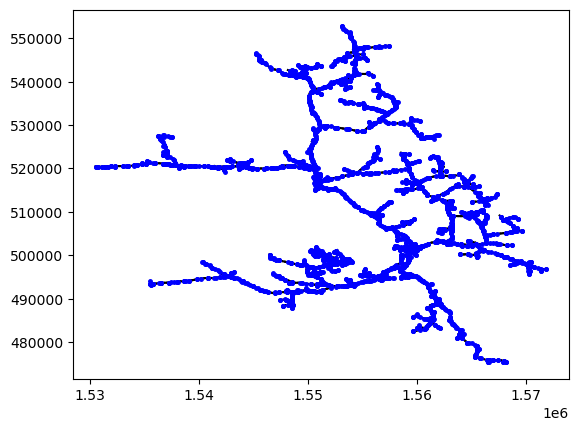

In [124]:
import matplotlib.pyplot as plt

## Plotting PKL
# Open pkl file
pkl_file = f"{root_dir}/Feeder_Data/{substation_name}/Python_Model/{substation_name}_Model.pkl"
with open(pkl_file, 'rb') as file:
    pkl_model = pickle.load(file)

# Get indices of substation nodes 
substation_inds = np.where(node_xs == np.min(node_xs))[0]
islanded_ind = [1322, 3091] # indices of nodes that exist in a separate island (excluded from translation)
DNE_devices_section_inds = [1228, 3466, 3674, 3811, 2690, 3162, 4435, 4436] # indices of sections to be excluded from translation (explanation below)
DNE_nodes = [4430, 4431] # indices of nodes to be excluded from translation (explanation below)

for Branch in pkl_model.Branches:
    branch_from_ind = Branch.from_node.split("_")
    branch_to_ind = Branch.to_node.split("_")
    for ii in range(len(branch_from_ind)):
        if branch_from_ind[ii].isnumeric():
            branch_from_ind = np.copy(branch_from_ind[ii:])
            break
    for ii in range(len(branch_to_ind)):
        if branch_to_ind[ii].isnumeric():
            branch_to_ind = np.copy(branch_to_ind[ii:])
            break
    # Only include nodes in plot if they are not substation nodes
    if all(int(x) not in substation_inds for x in branch_from_ind) and all(int(x) not in substation_inds for x in branch_to_ind):
        plt.plot([Branch.X_coord,Branch.X2_coord],[Branch.Y_coord,Branch.Y2_coord],color='black')

for Node in pkl_model.Nodes:
    node_ind = Node.name.split("_")
    for ii in range(len(node_ind)):
        if node_ind[ii].isnumeric():
            node_inds = np.copy(node_ind[ii:])
            break
    if all(int(x) not in substation_inds for x in node_inds):
        plt.plot(Node.X_coord,Node.Y_coord,'b.',markersize=5)

plt.show()